# Energy Efficiency (2) 

**Live coding demo on May 19, 2018**

In [31]:
%matplotlib notebook 

import json

import numpy as np 
import pandas as pd 
import seaborn as sns 
import yellowbrick as yb
import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.neural_network import MLPRegressor 
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import cross_val_score

## Data Loading

In [9]:
data = pd.read_csv("../data/energy/energy.csv")
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [15]:
with open("../data/energy/meta.json", "r") as f:
    meta = json.load(f)
    
columns = meta['feature_names'] + list(meta['target_names'].values())
data.columns = columns
data.head()

,relative compactness,surface area,wall area,roof area,overall height,orientation,glazing area,glazing area distribution,heating load,cooling load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [41]:
data.shape

(768, 10)

In [16]:
heating = data[meta['target_names']['Y1']]
cooling = data[meta['target_names']['Y2']]
features = data[meta['feature_names']]

In [18]:
features.head()

,relative compactness,surface area,wall area,roof area,overall height,orientation,glazing area,glazing area distribution
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


<IPython.core.display.Javascript object>


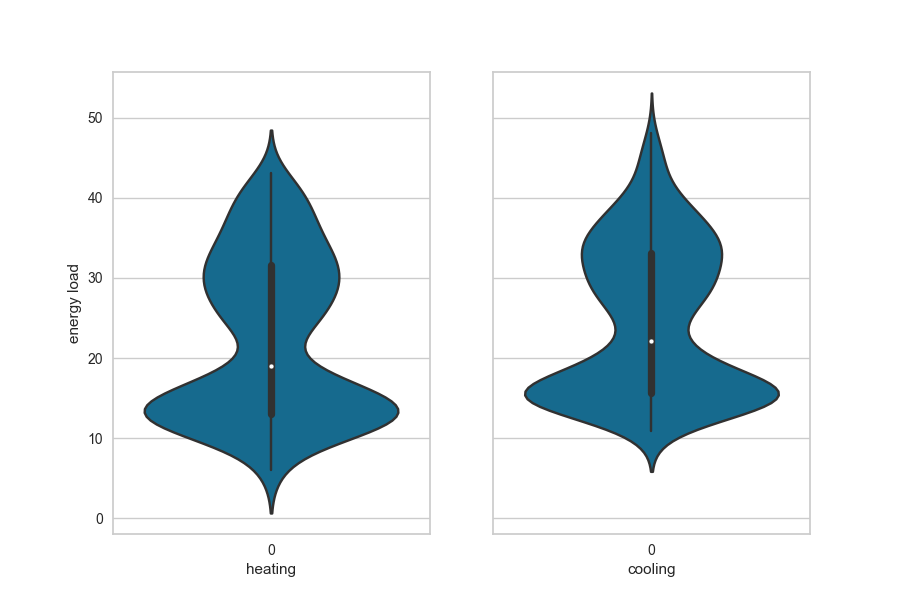

Text(0.5,0,'cooling')

In [29]:
_, axes = plt.subplots(1, 2, figsize=(9,6), sharey=True)

# Heating first 
h = sns.violinplot(data=heating, ax=axes[0])
h.set_ylabel("energy load")
h.set_xlabel("heating")

c = sns.violinplot(data=cooling, ax=axes[1])
c.set_xlabel("cooling")


<IPython.core.display.Javascript object>


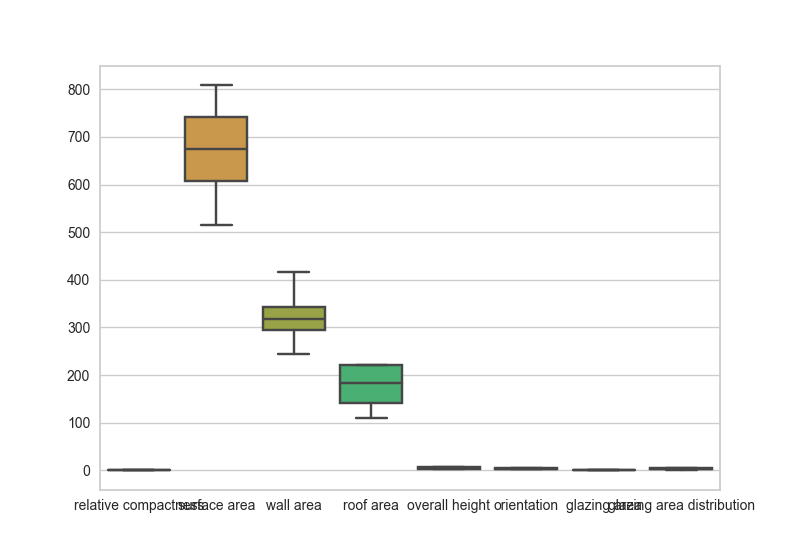

In [30]:
sns.boxplot(data=features)

## Linear and Polynomial Regressions

In [59]:
def build_poly(model, degree=1):
    if degree == 1:
        return Pipeline([
            ("std", StandardScaler()), 
            ("reg", model), 
        ])
    
    return Pipeline([
        ("std", StandardScaler()),
        ("poly", PolynomialFeatures(degree)), 
        ("reg", model), 
    ])


alphas = np.logspace(-6, 0, 200)

<IPython.core.display.Javascript object>


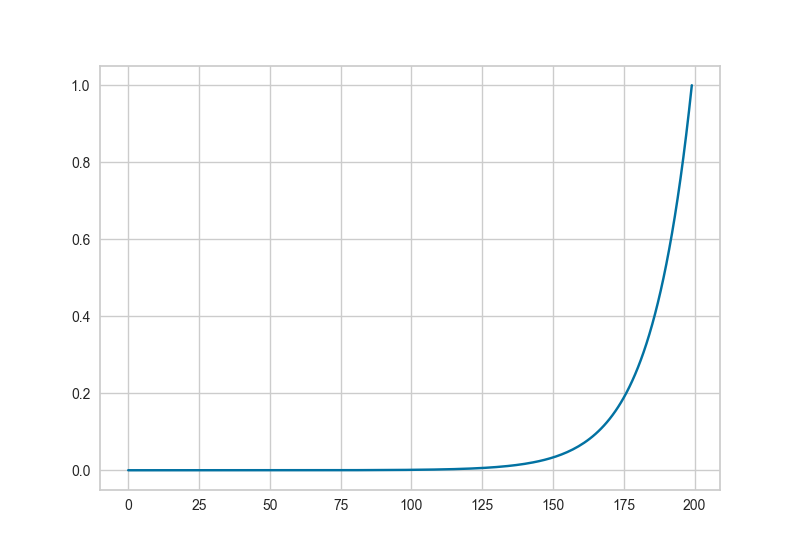

In [38]:
plt.plot(alphas)

In [43]:
# Ridge 
ridge_reg = build_poly(RidgeCV(alphas=alphas))
cross_val_score(ridge_reg, X=features, y=heating, cv=3)

array([0.81812578, 0.9189592 , 0.90371794])

In [56]:
ridge_reg.fit(features, heating)
print(ridge_reg._final_estimator.alpha_)
print(ridge_reg._final_estimator.coef_)

0.11623224686798518
[-6.70178939 -3.66740443  0.73499571 -3.93119914  7.33813269 -0.02607769
  2.65330353  0.31587548]


In [53]:
# Lasso 
lasso_reg = build_poly(LassoCV(alphas=alphas))
cross_val_score(lasso_reg, X=features, y=heating, cv=3)

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([0.81823595, 0.90881363, 0.90284712])

In [57]:
lasso_reg.fit(features, heating)
print(lasso_reg._final_estimator.alpha_)
print(lasso_reg._final_estimator.coef_)

1e-06
[-6.84351433 -7.22744064  2.4270302  -0.46314998  7.29881752 -0.02608064
  2.65371268  0.31583515]


/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


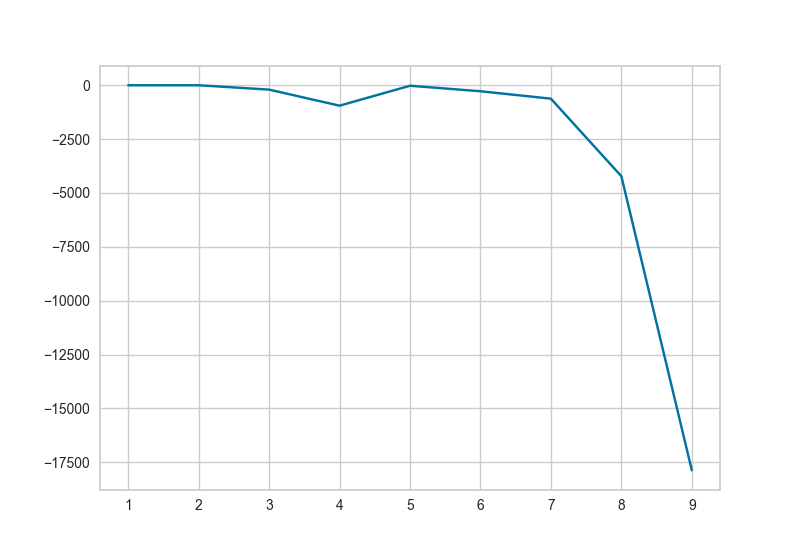

In [61]:
scores = []

for d in range(1, 10):
    reg = build_poly(RidgeCV(alphas=alphas), degree=d)
    scores.append(
        cross_val_score(reg, X=features, y=heating, cv=3).mean()
    )

scores = pd.Series(scores, index=range(1,10), name="$r^2$ of RidgeCV by degree")
scores.plot()

In [64]:
gb = build_poly(GradientBoostingRegressor())
cross_val_score(gb, X=features, y=heating, cv=3)

array([0.82543409, 0.94746752, 0.93229382])

In [67]:
gb.fit(features, heating)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
        ...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [72]:
gb._final_estimator.feature_importances_

array([0.23281328, 0.22199104, 0.16951871, 0.04807181, 0.06242108,
       0.04405539, 0.14126829, 0.0798604 ])

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<IPython.core.display.Javascript object>


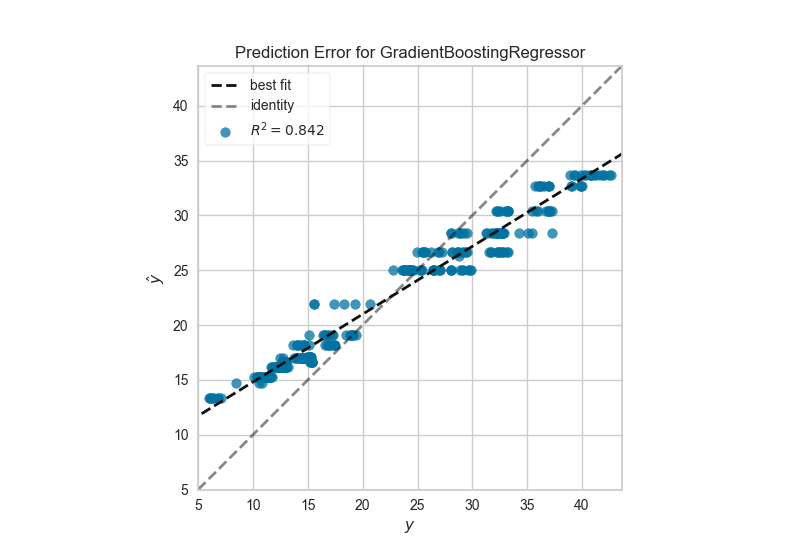

In [75]:
from sklearn.model_selection import train_test_split as tts
from yellowbrick.regressor import PredictionError

X_train, X_test, y_train, y_test = tts(features, heating, train_size=0.6)

oz = PredictionError(build_poly(GradientBoostingRegressor(n_estimators=10)))
oz.fit(X_train, y_train)
oz.score(X_test, y_test)
oz.poof()